In [1]:
#install pytorch
!pip3 install torch torchvision

     |████████████████████████████████| 753.4 MB 2.9 kB/s eta 0:00:010   |█▌                              | 34.2 MB 6.1 MB/s eta 0:01:58     |█▌                              | 35.5 MB 6.1 MB/s eta 0:01:58     |██                              | 46.5 MB 497 kB/s eta 0:23:42     |██████████▌                     | 246.4 MB 6.4 MB/s eta 0:01:20     |█████████████▉                  | 324.6 MB 3.6 MB/s eta 0:01:58███▉                 | 349.1 MB 4.8 MB/s eta 0:01:24     |█████████████████▋              | 415.3 MB 5.3 MB/s eta 0:01:04[K     |██████████████████▊             | 440.4 MB 5.4 MB/s eta 0:00:59   | 451.6 MB 4.8 MB/s eta 0:01:04     |███████████████████▍            | 455.6 MB 30.7 MB/s eta 0:00:10     |████████████████████▌           | 481.6 MB 3.6 MB/s eta 0:01:15     |███████████████████████▌        | 552.0 MB 6.2 MB/s eta 0:00:33     |████████████████████████▌       | 576.4 MB 5.9 MB/s eta 0:00:30     |█████████████████████████       | 588.2 MB 5.4 MB/s eta 0:00:31��████████▋    | 6

In [2]:
#import libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#resize and and normalize images
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
#download data
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#load data
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [5]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

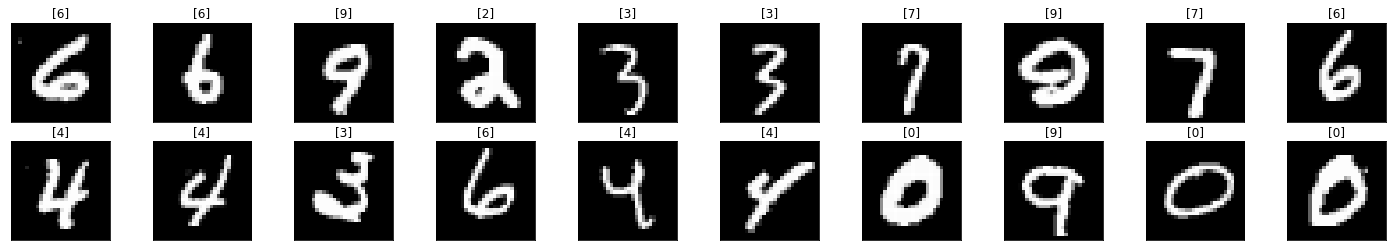

In [6]:
#plotting images with tag
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [7]:
#make model
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 20, 5, 1)
      self.conv2 = nn.Conv2d(20, 50, 5, 1)
      self.fc1 = nn.Linear(4*4*50, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*50)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
#compile model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
#train model
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.5767, acc 84.4767 
validation loss: 0.1775, validation acc 94.7300 
epoch : 2
training loss: 0.1497, acc 95.6183 
validation loss: 0.1060, validation acc 96.7800 
epoch : 3
training loss: 0.1003, acc 96.9667 
validation loss: 0.0740, validation acc 97.6400 
epoch : 4
training loss: 0.0763, acc 97.6683 
validation loss: 0.0623, validation acc 98.0700 
epoch : 5
training loss: 0.0652, acc 98.0667 
validation loss: 0.0526, validation acc 98.2600 
epoch : 6
training loss: 0.0546, acc 98.3383 
validation loss: 0.0452, validation acc 98.5500 
epoch : 7
training loss: 0.0493, acc 98.5067 
validation loss: 0.0423, validation acc 98.7500 
epoch : 8
training loss: 0.0438, acc 98.7117 
validation loss: 0.0381, validation acc 98.7400 
epoch : 9
training loss: 0.0395, acc 98.8300 
validation loss: 0.0380, validation acc 98.8100 
epoch : 10
training loss: 0.0361, acc 98.9217 
validation loss: 0.0344, validation acc 98.8100 
epoch : 11
training loss: 0.0335, acc 98.9283 
va

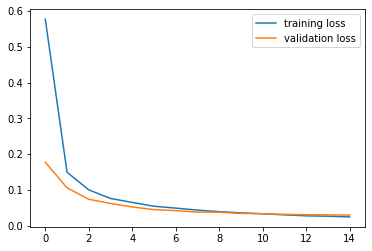

In [11]:
#plot training and validation loss
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

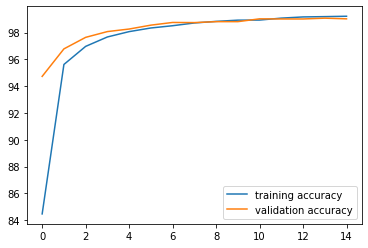

In [12]:
#plot training and validation accuracy
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [13]:
#download pillow
!pip3 install pillow==4.0.0

     |████████████████████████████████| 11.1 MB 2.8 MB/s eta 0:00:01
  Created wheel for pillow: filename=Pillow-4.0.0-cp37-cp37m-linux_x86_64.whl size=471743 sha256=1191f4edbe97e9fa421b9ee04265d99edda95e31ddbb772cdb710f55865772b0
  Stored in directory: /home/umair/.cache/pip/wheels/ec/1e/24/dbc5e4964ea99cad93230a9013d934fb5adc322c3102f69e45
Successfully built pillow
ERROR: torchvision 0.5.0 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
  Attempting uninstall: pillow
    Found existing installation: Pillow 6.2.0
    Uninstalling Pillow-6.2.0:
      Successfully uninstalled Pillow-6.2.0


Populating the interactive namespace from numpy and matplotlib


/home/umair/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


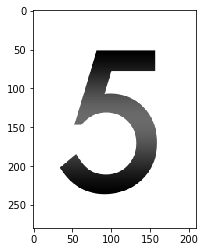

In [20]:
#plot an image of digit
%pylab inline
import matplotlib.image as mpimg
img=mpimg.imread('5.png')
plt.imshow(img)

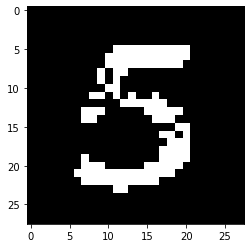

In [32]:
# convert image like handwritten
import PIL.ImageOps
from PIL import Image
img = img.convert('RGB')
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [33]:
#pridict img with model
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


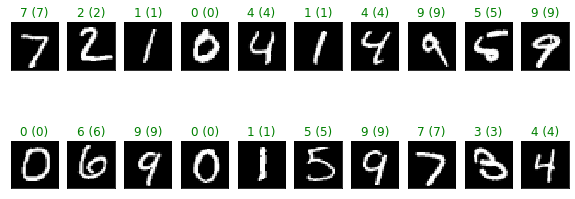

In [36]:
#predict random 20 images
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(10, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))